# W track modeling

- observation space is non-repeating two-well combinations of the 3 wells = 6 states 
- action space is the 3 wells 
- reward table would be the observation space x action space with values reinforcing alternation rule

In [645]:
import itertools
import random
import numpy as np
import matplotlib
%matplotlib inline

In [350]:
all_wells = ('A', 'B', 'C')
outer_wells = ('A', 'C')
home_well = ('B')

In [499]:
# all possible two-well non-repeating combinations
observation_space = list(itertools.product(all_wells, repeat=2))

In [500]:
# the possible actions at any state
action_space = all_wells

print('observation space {}\n'.format(observation_space))
print('action space {}'.format(action_space))

observation space [('A', 'A'), ('A', 'B'), ('A', 'C'), ('B', 'A'), ('B', 'B'), ('B', 'C'), ('C', 'A'), ('C', 'B'), ('C', 'C')]

action space ('A', 'B', 'C')


In [520]:
# get rewarded sequences to populate reward table
sequences = list(itertools.product(all_wells, repeat=3))

outbound_rewarded_sequences = []
inbound_rewarded_sequences = []
for seq in sequences:
    if seq[0] in outer_wells and seq[2] in outer_wells and seq[0] != seq[2] and seq[1] in home_well:
        outbound_rewarded_sequences.append(seq)
    if seq[0] in home_well and seq[1] in home_well and seq[2] in outer_wells:
        #special case that i'm making up: the out bound correct arm 'resets' if the last two wells visited were the home well
        outbound_rewarded_sequences.append(seq)
    if seq[1] in outer_wells and seq[2] in home_well:
        inbound_rewarded_sequences.append(seq)

print('outbound rewarded sequences {}\n'.format(outbound_rewarded_sequences))
print('inbound rewarded sequences {}\n'.format(inbound_rewarded_sequences))

outbound rewarded sequences [('A', 'B', 'C'), ('B', 'B', 'A'), ('B', 'B', 'C'), ('C', 'B', 'A')]

inbound rewarded sequences [('A', 'A', 'B'), ('A', 'C', 'B'), ('B', 'A', 'B'), ('B', 'C', 'B'), ('C', 'A', 'B'), ('C', 'C', 'B')]



In [521]:
def make_reward_table():
    reward_table = {}
    for obsv in observation_space:
        current_well = obsv[-1]
        reward_table[obsv] = {}
        for act in action_space:
            reward_table[obsv][act] = {}
#             if act == current_well:
#                 # if the action is the same as the most recent well, 
#                 # loop back obvs state and draw penalty
#                 reward_table[obsv][act]['next_state'] = obsv
#             else:
            reward_table[obsv][act]['next_state'] = tuple([current_well, act])
            # set reward value
            if obsv + tuple(act) in outbound_rewarded_sequences:
                reward_table[obsv][act]['reward'] = 1
            elif obsv + tuple(act) in inbound_rewarded_sequences:
                reward_table[obsv][act]['reward'] = 1
            else:
                reward_table[obsv][act]['reward'] = 0
    return reward_table

In [522]:
# initialize q table to zeros
def init_q_table():
    q_table = {}
    for obsv in observation_space:
        q_table[obsv] = {}
        for act in action_space:
            q_table[obsv][act] = 0
    return q_table

In [523]:
def check_q_table(q_table):
    #quick check if q table, followed greedily without further updates, is consistent with W rules
    if type(q_table) == dict:
        q_table_max_sequences = [tuple(list(state) + list(max(actions, key=lambda act: actions[act]))) for state, actions in q_table.items()]
    elif type(q_table) == pd.DataFrame:
        smax = q_table_df.idxmax(axis=1)
        q_table_max_sequences = [ind + tuple(maxv) for ind, maxv in zip(smax.index, smax.values)]
        print(q_table_max_sequences)
    check = set(q_table_max_sequences).issubset(outbound_rewarded_sequences+inbound_rewarded_sequences)
    if check:
        print('q_table consistent with W-TRACK rules')
    else:
        print('q_table NOT consistent with W-TRACK rules')
    return 

In [524]:
def init_state_df():
    zeros_array = np.zeros((len(observation_space), len(action_space)))
    state_df = pd.DataFrame(zeros_array, index=observation_space, columns=action_space)
    return state_df

In [525]:
reward_table = make_reward_table()

# Q-Learning with e-greedy

In [697]:
%%time

alpha = 0.6
gamma = 0.9
epsilon = 0.1

q_table_df = init_state_df()

state = random.choice(observation_space)
q_learn_rewards = []

for i in range(1, 1000):
    # act
    if random.uniform(0, 1) < epsilon:
        # Explore action space
        action = random.choice(all_wells)
    else:
        action = q_table_df.xs(state).idxmax()
    # gather
    # gather
    reward = reward_table[state][action]['reward']
    next_state = reward_table[state][action]['next_state']
    
    old_qvalue = q_table_df.xs(state)[action]
    next_max_qvalue = q_table_df.xs(next_state).max()
    
    # update
    new_value = (1 - alpha) * old_qvalue + alpha * (reward + gamma * next_max_qvalue)
    q_table_df.xs(state)[action] = new_value

    # iterate
    state = reward_table[state][action]['next_state']
    #save
    q_learn_rewards.append(reward)


CPU times: user 611 ms, sys: 10.3 ms, total: 621 ms
Wall time: 709 ms


In [698]:
q_table_df

,A,B,C
"(A, A)",2.829317,6.678941,2.288005
"(A, B)",5.878449,6.309951,5.611071
"(A, C)",5.380966,0.000000,0.000000
"(B, A)",6.005986,6.678955,4.688727
"(B, B)",7.011058,6.281762,5.299796
"(B, C)",5.383844,0.000000,0.000000
"(C, A)",6.010800,3.157890,2.545236
"(C, B)",0.000000,0.000000,0.000000
"(C, C)",3.226855,0.000000,0.000000


In [699]:
check_q_table(q_table_df)

[('A', 'A', 'B'), ('A', 'B', 'B'), ('A', 'C', 'A'), ('B', 'A', 'B'), ('B', 'B', 'A'), ('B', 'C', 'A'), ('C', 'A', 'A'), ('C', 'B', 'A'), ('C', 'C', 'A')]
q_table NOT consistent with W-TRACK rules


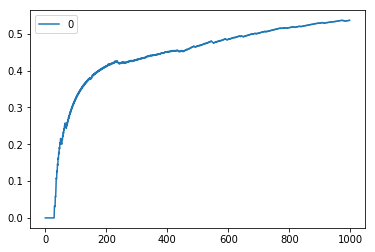

In [700]:
q_learn_norm_rewards = np.cumsum(q_learn_rewards)/np.arange(1,len(q_learn_rewards)+1)
pd.DataFrame(q_learn_norm_rewards).plot()

# TD(0) with e-greedy

In [701]:
%%time

alpha = 0.6
gamma = 0.9
epsilon = 0.1

q_table_df = init_state_df()

state = random.choice(observation_space)
TD_zero_rewards = []

for i in range(1, 1000):
    # act
    if random.uniform(0, 1) < epsilon:
        # Explore action space
        action = random.choice(all_wells)
    else:
        action = q_table_df.xs(state).idxmax()
    # gather
    reward = reward_table[state][action]['reward']
    next_state = reward_table[state][action]['next_state']
    
    old_qvalue = q_table_df.xs(state)[action]
    next_max_qvalue = q_table_df.xs(next_state).max()

    #update
    td_error = reward + gamma * next_max_qvalue - old_qvalue
    new_value = alpha * td_error
    q_table_df.xs(state)[action] = new_value
    
    # iterate
    state = reward_table[state][action]['next_state']
    #save
    TD_zero_rewards.append(reward)

CPU times: user 586 ms, sys: 7.9 ms, total: 594 ms
Wall time: 675 ms


In [702]:
q_table_df

,A,B,C
"(A, A)",-0.028643,0.581058,0.000000
"(A, B)",0.214193,0.194618,0.566041
"(A, C)",0.161470,0.000000,0.000000
"(B, A)",0.102550,0.566042,0.130118
"(B, B)",0.566047,0.000000,0.000000
"(B, C)",0.160329,0.566039,0.007659
"(C, A)",-0.032710,0.565831,0.000000
"(C, B)",0.566033,0.189272,0.205891
"(C, C)",0.201124,0.000000,0.000000


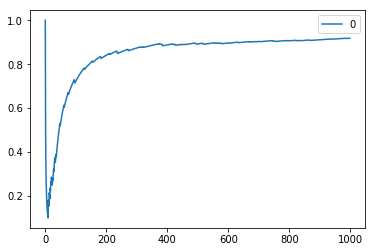

In [703]:
TD_zero_norm_rewards = np.cumsum(TD_zero_rewards)/np.arange(1,len(TD_zero_rewards)+1)
pd.DataFrame(TD_zero_norm_rewards).plot()

In [704]:
check_q_table(q_table_df)

[('A', 'A', 'B'), ('A', 'B', 'C'), ('A', 'C', 'A'), ('B', 'A', 'B'), ('B', 'B', 'A'), ('B', 'C', 'B'), ('C', 'A', 'B'), ('C', 'B', 'A'), ('C', 'C', 'A')]
q_table NOT consistent with W-TRACK rules


# TD(lambda) with e-greedy

In [710]:
%%time

lamb = 0.9
alpha = 0.6
gamma = 0.9
epsilon = 0.1

q_table_df = init_state_df()
eligibility_df = init_state_df()

state = random.choice(observation_space)
TD_lamb_rewards = []

for i in range(1, 1000):
    # act
    if random.uniform(0, 1) < epsilon:
        # Explore action space
        action = random.choice(all_wells)
    else:
        action = q_table_df.xs(state).idxmax()
    # gather
    reward = reward_table[state][action]['reward']
    next_state = reward_table[state][action]['next_state']
    
    old_qvalue = q_table_df.xs(state)[action]
    next_max_qvalue = q_table_df.xs(next_state).max()
    
    # update eligibility
    eligibility_df *= lamb * gamma
    eligibility_df.xs(state)[action] += 1.0
    
    #update
    td_error = reward + gamma * next_max_qvalue - old_qvalue
    new_value = alpha * td_error
    eligibility_df *= new_value
    q_table_df += eligibility_df
    
    # iterate
    state = reward_table[state][action]['next_state']
    #save
    TD_lamb_rewards.append(reward)

CPU times: user 1.32 s, sys: 13.7 ms, total: 1.33 s
Wall time: 1.47 s


In [711]:
q_table_df

,A,B,C
"(A, A)",6.845222,10.012916,4.760817
"(A, B)",8.916494,9.171275,10.007131
"(A, C)",7.622868,0.000000,0.000000
"(B, A)",8.753182,10.007109,6.413837
"(B, B)",10.033163,0.000000,5.909122
"(B, C)",7.954667,10.007106,3.794119
"(C, A)",8.981178,6.232749,4.181366
"(C, B)",10.006826,8.873886,2.696114
"(C, C)",6.308098,6.015977,3.996793


In [712]:
check_q_table(q_table_df)

[('A', 'A', 'B'), ('A', 'B', 'C'), ('A', 'C', 'A'), ('B', 'A', 'B'), ('B', 'B', 'A'), ('B', 'C', 'B'), ('C', 'A', 'A'), ('C', 'B', 'A'), ('C', 'C', 'A')]
q_table NOT consistent with W-TRACK rules


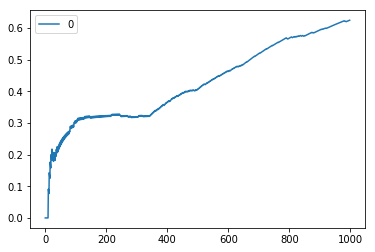

In [713]:
TD_lamb_norm_rewards = np.cumsum(TD_lamb_rewards)/np.arange(1,len(TD_lamb_rewards)+1)
pd.DataFrame(TD_lamb_norm_rewards).plot()

# TD(lambda) with memory unit

In [714]:
def init_mem_obv_df():
    mem_obv_pairs = list(itertools.product(all_wells, repeat=2))
    zeros_array = np.random.rand(len(mem_obv_pairs), len(action_space))
    mem_df_indx = pd.DataFrame(mem_obv_pairs).rename({0:'mem',1:'obsv'}, axis=1).set_index(['mem','obsv']).index
    mem_df = pd.DataFrame(zeros_array, index=mem_df_indx, columns=action_space)
    return mem_df

In [715]:
def init_memory_unit_df():
    zeros_array = np.random.rand(len(action_space), len(action_space))
    mem_df = pd.DataFrame(zeros_array, index=action_space, columns=action_space)
    return mem_df

In [716]:
%%time

lamb = 0.9
alpha = 0.6
gamma = 0.9
epsilon = 0.1

q_table_df = init_mem_obv_df()
eligibility_df = init_mem_obv_df()

mem_df = init_memory_unit_df()
mem_eligibility_df = init_memory_unit_df()

mem = random.choice(action_space)
obsv = random.choice(action_space)
TD_lamb_mem_rewards = []

for i in range(1, 1000):
    # act
    if random.uniform(0, 1) < epsilon:
        # Explore action space
        action = random.choice(all_wells)
    else:
        action = q_table_df.xs([mem, obsv]).idxmax()

    # gather
    reward = reward_table[(mem, obsv)][action]['reward']
    next_obsv = action
    next_mem = mem_df.xs(next_obsv).idxmax()
    next_state = [next_mem, next_obsv]
    
    old_qvalue = q_table_df.xs([mem, obsv])[action]
    next_max_qvalue = q_table_df.xs(next_state).max()
    
    # update qtable eligibility
    eligibility_df *= lamb * gamma
    eligibility_df.xs([mem, obsv])[action] += 1.0
    
    # update memory table eligibility
    mem_eligibility_df += lamb * gamma
    mem_eligibility_df.xs(mem)[obsv] += 1.0
    
    #get target value (scaled td error)
    td_error = reward + gamma * next_max_qvalue - old_qvalue
    new_value = alpha * td_error
    
    #update eligibility tables
    eligibility_df *= new_value
    mem_eligibility_df *= new_value
    
    #update q_table and memory unit table
    q_table_df += eligibility_df
    mem_df += mem_eligibility_df
    
    # iterate
    mem = next_mem
    obsv = action

    #save
    TD_lamb_mem_rewards.append(reward)

CPU times: user 2.76 s, sys: 20.6 ms, total: 2.78 s
Wall time: 2.85 s


In [717]:
mem_df

,A,B,C
A,84.879858,57.621341,57.814544
B,57.720802,57.510587,72.170355
C,58.012065,84.164226,62.085301


In [718]:
q_table_df

A          B         C
mem obsv                                
A   A      8.999997  10.000000  9.000478
    B      0.323624   0.757474  0.576111
    C      0.431938   0.955683  0.459913
B   A      0.542359   0.321450  0.592016
    B      0.894336   1.107495  0.980797
    C      5.575648  10.000000  0.894466
C   A      0.433719   0.579052  0.407569
    B     10.000000   8.999991  8.995978
    C      3.032043   0.688569  2.205636

In [719]:
check_q_table(q_table_df)

[('A', 'A', 'B'), ('A', 'B', 'B'), ('A', 'C', 'B'), ('B', 'A', 'C'), ('B', 'B', 'B'), ('B', 'C', 'B'), ('C', 'A', 'B'), ('C', 'B', 'A'), ('C', 'C', 'A')]
q_table NOT consistent with W-TRACK rules


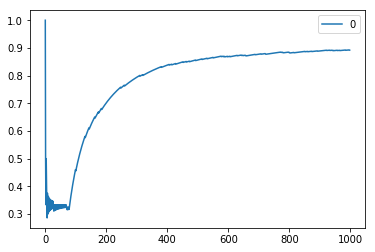

In [720]:
TD_lamb_mem_norm_rewards = np.cumsum(TD_lamb_mem_rewards)/np.arange(1,len(TD_lamb_mem_rewards)+1)
pd.DataFrame(TD_lamb_mem_norm_rewards).plot()

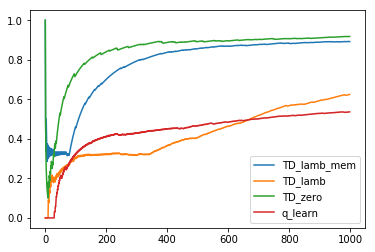

In [721]:
rewards = [TD_lamb_mem_norm_rewards, TD_lamb_norm_rewards, TD_zero_norm_rewards, q_learn_norm_rewards]
rewards_array = np.vstack(rewards).T

rewards_df = pd.DataFrame(rewards_array, columns=['TD_lamb_mem', 'TD_lamb', 'TD_zero', 'q_learn'])

rewards_df.plot()